SNe parametric model (Villar et al, ALeRCE):

\begin{align}
early(t) &=\frac{A\left(1-f\frac{t-t_0}{\gamma}\right)}{1+exp\left(\frac{-(t-t_0)}{t_{rise}}\right)}\left(1-\sigma\left(\frac{t-(\gamma + t_0)}{3}\right)\right)\\
late(t) &= \frac{A(1-f)exp\left(\frac{-(t-(\gamma+t_0))}{t_{fall}}\right)}{1+exp\left(\frac{-(t-t_0)}{t_{rise}}\right)}\sigma\left(\frac{t-(\gamma + t_0)}{3}\right)\\
flux(t) &= early(t)+late(t)>0
\end{align}
Where $t$ is the time, in day units, of the light curve, and $\sigma(t)=1/(1+exp(-t))$ is the sigmoid function.

Parameters:
1. $t_0$ time close to the maximum curve flux (peak).
1. $A>0$ controls the global curve scale.
1. $\gamma>0$ associated with the plateau duration.
1. $t_{rise}>0$ controls the time to maximum flux value (peak).
1. $t_{fall}>0$ mostly associated with the flux fall duration after plateau.
1. $0<f<1$ associated with plateau slope value.


In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../../../flaming-choripan')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


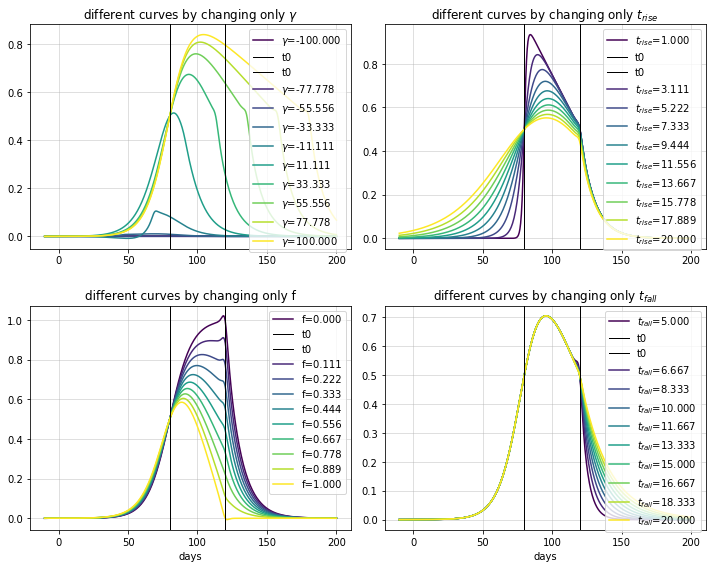

In [18]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from lchandler.synthetic.synthetic_curve_generators import syn_sne_fnumpy
import flamingchoripan.cuteplots.colors as cc
from matplotlib import cm
import numpy as np
import random
      
NT = 400
N = 10
times = np.linspace(-10, 200, NT)

A = 1
t0 = 80
gamma = 40
f = 0.5
trise = 8
tfall = 10

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = [axs[0,0], axs[1,0],axs[0,1],axs[1,1]]
ch_list = []
ch_list.append(zip(np.linspace(-100, 100, N),['gamma']*N,['$\gamma$']*N))
ch_list.append(zip(np.linspace(0, 1, N),['f']*N,['f']*N))
ch_list.append(zip(np.linspace(1, 20, N),['trise']*N,['$t_{rise}$']*N))
ch_list.append(zip(np.linspace(5, 20, N),['tfall']*N,['$t_{fall}$']*N))

for k,ax in enumerate(axs):
    cmap = cm.get_cmap('viridis', N)
    colors = cmap.colors
    for kv,(v_value,v_name,v_legend) in enumerate(ch_list[k]):
        kwargs = {
            'A':A,
            't0':t0,
            'gamma':gamma,
            'f':f,
            'trise':trise,
            'tfall':tfall,
            's':1,
        }
        kwargs[v_name] = v_value
        flux = syn_sne_fnumpy(times, *[kwargs[k] for k in kwargs.keys()])
        label = f'{v_legend}={v_value:.3f}'
        ax.plot(times, flux, c=colors[kv], label=label)
        ax.axvline(t0, c='k', label='t0' if kv==0 else None, alpha=1, lw=1)
        ax.axvline(t0+gamma, c='k', label='t0' if kv==0 else None, alpha=1, lw=1)
        
    ax.set_title(f'different curves by changing only {v_legend}')
    ax.legend()
    if k in [1,3]:
        ax.set_xlabel('days')
    #ax.set_ylabel('flux')
    ax.grid(alpha=0.5)
    
fig.tight_layout()
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from flamingchoripan.cutePlots.plots import plot_hist_bins
import flamingchoripan.cutePlots.colors as cpc
from scipy.stats import gamma

sigma_error_arguments = {
    'loc':1e-3,
    'shape':1.8,
    'scale':0.01,
}
N = int(1e4)
shape, scale = sigma_error_arguments['shape'], sigma_error_arguments['scale']
samples = np.random.gamma(shape, scale, size=N)
samples += sigma_error_arguments['loc']

data_dic = {'gamma distribution':samples}
fig, ax, handles = plot_hist_bins(data_dic, uses_density=True, return_legend_patches=True)
x = np.linspace(0, np.max(samples), int(1e4))
y = gamma.pdf(x, shape, sigma_error_arguments['loc'], scale)
label = f'gamma(shape={shape}, scale={scale})'
ax.plot(x, y, linewidth=2, color=cpc.colors()[1], label=label)
handles_, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles+handles_)
plt.plot()

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random
from src.synth.synthetic_SNe import generate_FSNe
from itertools import chain
from flamingchoripan.myUtils.progress_bars import ProgressBar
import astrolightcurveshandler.src.data_classes as lcdc # auxiliar import
from src import C_

survey_name = 'FakeSNe'
band_names = ['g', 'r']
class_names = ['short', 'long','small']
description = 'fake supernovaes for sanity checks'

# PREPARE NEW DATASET
lcset = lcdc.LCSet(
    {},
    survey_name,
    description,
    band_names,
    class_names,
    True,
)
raw_lcdataset = lcdc.LCDataset()
raw_lcdataset.set_raw(lcset)

N_curvesteps = 20
times = np.linspace(-100, 100, NT)
max_nc = 1e3
nc_dict = {
    'short':.6,
    'long':.3,
    'small':.1,
}
curve_points_dropout = 0.92

labels = list(chain.from_iterable([[kc]*int(nc_dict[c]*max_nc) for kc,c in enumerate(class_names)]))
random.shuffle(labels)
print(f'labels: {len(labels)}')

bar = ProgressBar(len(labels))
for k,label in enumerate(labels):
    obj_name = k
    bar(f'obj_name: {obj_name}')
    lcobj = lcdc.LCO()
    SNe_kwargs = None
    for kb,b in enumerate(band_names):
        SNe_type = class_names[label]
        f_return = generate_FSNe(SNe_type, times, curve_points_dropout, sigma_error_arguments, SNe_kwargs=SNe_kwargs)
        band_lc_flux, theorical_model = f_return
        lcobj.add_b(b, band_lc_flux[:,0], band_lc_flux[:,1], band_lc_flux[:,2])
        SNe_kwargs = theorical_model.copy()
        SNe_kwargs['A'] *= 0.9 # example for slightly different bands
    
    lcobj.reset_day_offset_serial()
    lcobj.set_y(label)
    lcobj.z = 0 # redshift
    lcobj.ra = 0
    lcobj.dec = 0
    raw_lcdataset.raw.data[obj_name] = lcobj
    
bar.done()

In [ ]:
import flamingchoripan.myUtils.lists as lists
import matplotlib.pyplot as plt
from src.plots import plot_lightcurve

lcobj, key = raw_lcdataset.raw.get_random_lcobj()
#print(lcobj)
fig, ax = plt.subplots(1,1)
for kb,b in enumerate(raw_lcdataset.raw.band_names):
    plot_lightcurve(ax, lcobj, b)

In [ ]:
%load_ext autoreload
%autoreload 2
from flamingchoripan.myUtils.files import save_pickle
from src import C_

save_folder = '../save/{}'.format(survey_name)
filename = f'survey-{survey_name}_bands-{"".join(band_names)}_classes-{len(class_names)}'
filedir = f'{save_folder}/{filename}.{C_.EXT_RAW_LIGHTCURVE}'
save_pickle(filedir, raw_lcdataset)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import flamingchoripan.cutePlots.colors as cpc
from src import C_

def get_random_keys(data, class_names, Nc):
    all_keys = list(data.keys())
    random.shuffle(all_keys)
    counter = {c:0 for c in class_names}
    keys = []
    for key in all_keys:
        y = data[key]['y']
        if counter[class_names[y]] < Nc:
            keys.append(key)
            counter[class_names[y]] += 1
    return keys

figsize = (12,10)
fig, axs = plt.subplots(len(band_names), 1, figsize=figsize)

Nc = 1
keys = get_random_keys(data, class_names, Nc)
print('keys:',keys)

#colors = cm.Dark2(np.linspace(.0, .999, len(keys)))
colors = cpc.colors()[0:]
for kb,band in enumerate(band_names):
    ax = axs[kb]
    for k,key in enumerate(keys):
        obj = data[key]
        class_name = class_names[obj['y']]
        lc = obj['x_mb'][band]
        iday = obj['iday']
        print(iday)
        days = lc[:,0]
        c = colors[k]
        plot_lightcurve(ax, days, lc[:,1], lc[:,2], label=f'{class_name}', color=c)
        
    ax.set_title(f'survey_name: {survey_name} - band: {band}')
    ax.legend()
    ax.grid(alpha=0.5)
    #ax.invert_yaxis()
    ax.set_ylabel('flux')
    
ax.set_xlabel('days')
plt.plot()

In [ ]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

samples = []
band = 'g'
for k,key in enumerate(data.keys()):
    parameters = data[key]['tm_mb'][band]
    parameters = [parameters[k] for k in parameters][:-2]
    samples.append(np.array(parameters)[None])
    
samples = np.concatenate(samples, axis=0)
labels = ['A','t0','$\gamma$','f','$t_{rise}$','$t_{fall}$']
df = pd.DataFrame(samples, columns=labels)
df['class'] = [class_names[data[key]['y']] for key in data.keys()]
print(df)
figsize = (5, 5)
sns.pairplot(df, hue='class')

In [ ]:
import corner
import numpy as np

keys = data.keys()
samples = []
band = 'g'
for k,key in enumerate(keys):
    parameters = data[key]['tm_mb'][band]
    parameters = [parameters[k] for k in parameters]
    sample = np.array(parameters)[None,:-2]
    samples.append(sample)
    
figsize = (3, 3)
samples = np.concatenate(samples, axis=0)
labels = ['A','t0','$\gamma$','f','$t_{rise}$','$t_{fall}$']
figure = corner.corner(samples, labels=labels, figsize=figsize)